## Set-up (for colab)
---

In [1]:
%%capture
!pip install pymc3==3.11

# PyShopper example
---
- This notebook contains a quick example of PyShopper that includes:
1. Loading data
2. Instantiating and fitting the Shopper model via MCMC sampling or variational inference
3. Inference diagnostics
4. Prediction on unseen test data

In [2]:
# Imports

import numpy as np
import pandas as pd
import filelock
import warnings

import theano

from pyshopper import shopper

from tqdm.notebook import tqdm

# Ignore FutureWarning and UserWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
import logging
logger = logging.getLogger('filelock')
logger.setLevel(logging.WARNING)

In [4]:
# URL to datasets
DATA_URL = 'https://github.com/topher-lo/PyShopper/blob/main/data'

## 1. Load data
---

In [5]:
# Load data
data = shopper.load_data(f'{DATA_URL}/train.tsv?raw=true', f'{DATA_URL}/prices.tsv?raw=true')
unique_items = sorted(data['item_id'].unique())
sessions_list = sorted(data['session_id'].unique())

# Limit data to C (most frequent) items and W sessions
# Note: we filter for trailing sessions because the tested dataset's sessions begin at the end of
# the training dataset's sessions
C = 2
W = 10

# Filter data
X_train = (data.loc[data['item_id'].isin(unique_items[:C])]
               .loc[data['session_id'].isin(sessions_list[-W:])]
               .reset_index(drop=True))

X_train

,user_id,item_id,session_id,quantity,price
0,1,100,391,1,1.0
1,2,100,391,1,1.0
2,3,100,391,1,1.0
3,4,100,391,1,1.0
4,5,100,391,1,1.0
...,...,...,...,...,...
1157,94,101,394,1,5.0
1158,112,101,394,1,5.0
1159,113,101,394,1,5.0
1160,114,101,394,1,5.0


## 2. Instantiate and fit model
---

In [6]:
# Create Shopper instance

model = shopper.Shopper(X_train)

INFO:root:Building the Shopper model...
INFO:root:Done building the Shopper model.


In [7]:
# # Fit model with MCMC sampling

# mcmc_res = model.fit(N=10000, method='MCMC')

In [8]:
# # Results summary:
# # Summary of common posterior statistics 
# # and sampling diagnostics

# mcmc_res.summary()

In [9]:
# Fit model with ADVI approximation

advi_res = model.fit(N=10, method='ADVI')

Finished [100%]: Average Loss = 42,522
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 42,522


In [10]:
# # Results summary:
# # Summary of common posterior statistics
# # Note: must define number of draws from approximated posterior distribution

# advi_res.summary(draws=5)

## 3. Diagnostics
---

In [11]:
# # Sampling trace plot

# mcmc_res.trace_plot()

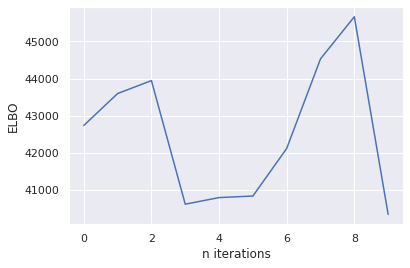

In [12]:
# ELBO plot (ADVI)

fig = advi_res.elbo_plot()

## 4. Prediction
---

In [13]:
# Load test data
test_data = shopper.load_data(f'{DATA_URL}/test.tsv?raw=true',
                              f'{DATA_URL}/prices.tsv?raw=true')
test_sessions_list = sorted(test_data['session_id'].unique())

W_test = int(0.33*W)

# Limit data to C items and U users
X_test = (test_data.loc[test_data['item_id'].isin(unique_items[:C])]
                   .loc[test_data['session_id'].isin(test_sessions_list[-W_test:])]
                   .reset_index(drop=True))

X_test

,user_id,item_id,session_id,quantity,price
0,3,100,429,1,5.0
1,13,100,429,1,5.0
2,30,100,429,1,5.0
3,64,100,429,1,5.0
4,69,100,429,1,5.0
...,...,...,...,...,...
62,83,100,428,1,5.0
63,109,100,428,1,5.0
64,114,100,428,1,5.0
65,123,100,428,1,5.0


In [14]:
# ADVI Predictions

advi_res.predict(X_test, draws=10)

INFO:root:Sampling from posterior distribution...
INFO:root:Sampling complete.


array([[23, 65, 47, 41, 14,  5,  1, 62, 42, 57,  0, 55, 51,  6,  5, 14,
        19, 39, 36, 32, 34,  4, 19, 21, 37, 59, 14, 39, 32,  2, 42,  5,
         2, 64, 65, 50, 32,  3, 44, 37, 13, 31,  1, 63,  8, 44, 21, 39,
        40,  5, 65, 49, 64, 62, 42, 54, 12, 15,  1, 33, 22, 17, 61, 21,
        18, 40, 12],
       [60, 11, 56, 59, 15,  9, 60, 47, 50, 49, 11, 22, 10, 62, 30, 20,
         3, 32, 32, 47, 43, 53, 38,  4, 51, 48, 30, 57, 36, 38, 25,  0,
        12,  9, 43, 33, 26, 53, 17, 36, 48, 16, 11, 32, 14, 64, 60, 43,
        52, 50, 15, 61, 40, 60, 53, 20,  3,  7, 23, 61, 52,  0, 39, 36,
         7,  5, 21],
       [55, 20, 39, 46, 22, 65, 55, 17, 26, 32, 18,  9, 37, 36, 10, 17,
        53, 17, 13, 26, 66,  7, 44, 48, 17, 47, 33, 40, 31, 29,  3, 58,
        20,  5, 10, 41, 45,  1, 26,  7, 40,  9, 57, 26, 54,  4, 31, 12,
        64, 52, 18, 45, 60, 40, 39,  8,  3, 62, 53, 43, 21, 33, 47, 53,
        63, 49, 43],
       [ 9, 14, 53, 42,  0,  9, 44,  0, 14, 28, 46, 43,  8, 46,  7, 20,
 